In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import torch

In [2]:
ds = np.lib.DataSource()
fp = ds.open('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
df = pd.read_csv(fp, header=None, delimiter=',')
X = df.iloc[:,:-1].values
mu, std = np.mean(X, axis=0), np.std(X, axis=0)
X = (X - mu) / std
y = df.iloc[:, -1]
for i, c in enumerate(pd.unique(y)):
    y = y.replace(c, i)
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MultiClassLogisticRegression:
    def _forward(self, x):
        z = torch.mm(x, self.w) + self.b
        return self._softmax(z)
    def _backward(self, a, y):
        return y - a
    def _softmax(self, z):
        return torch.exp(z) / torch.sum(torch.exp(z), axis=1).unsqueeze(1)
    def _one_hot(self, y):
        unique_y = list(np.unique(y))
        _one_hot_y = torch.zeros((len(y), len(unique_y)), device=device)
        for i, c in enumerate(y):
            _one_hot_y[i][unique_y.index(c)] = 1
        return _one_hot_y
    def _cost(self, y, a):
        return -torch.mean(torch.sum(y * torch.log(a), axis=1))
    def predict(self, x):
        return torch.argmax(self._forward(x), axis=1)
    def score(self, x, y):
        return (self.predict(x) == y).numpy().mean()
    def train(self, x, y, num_epochs=1000, learning_rate=0.01):
        self.unique_y = torch.unique(y)
        self.w = torch.zeros((x.size()[1], len(self.unique_y)), dtype=torch.float32, device=device)
        self.b = torch.zeros(len(self.unique_y), dtype=torch.float32, device=device)
        y = self._one_hot(y)
        costs = []
        for i in range(num_epochs):
            # forward propagation
            a  = self._forward(x)
            # backward propagation
            dz = self._backward(a, y)
            dw = torch.mm(x.T, dz) #/ len(x)
            db = torch.mean(dz, axis=0)
            # update parameters
            self.w += learning_rate * dw
            self.b += learning_rate * db
            # accumulate loss
            cost = self._cost(y, self._forward(x))    
            costs.append(cost)
        print(f"Weights:\n{self.w}")
        print(f"Bias:\n{self.b}")
        costs = np.squeeze(costs)
        plt.plot(costs)
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
        return self

Weights:
tensor([[-0.6103,  0.3418,  0.2685],
        [ 1.0195, -0.9924, -0.0271],
        [-1.1238,  0.3034,  0.8204],
        [-1.0241, -0.1729,  1.1970]])
Bias:
tensor([-0.0072,  0.0190, -0.0118])


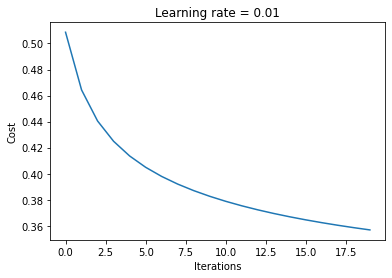

In [4]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, device=device)
y_test_tensor  = torch.tensor(y_test,  device=device)

logr = MultiClassLogisticRegression()
logr.train(X_train_tensor, y_train_tensor, 20)

In [5]:
print(f"\nScore: {logr.score(X_test_tensor, y_test_tensor)*100:.2f}%\n")


Score: 93.33%

